In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import os

In [2]:
def explore_h5(file_path):
    with h5py.File(file_path, 'r') as f:
        def explore_group(group, prefix=''):
            for key in group.keys():
                item = group[key]
                if isinstance(item, h5py.Group):
                    print(f"Group: {prefix}/{key}")
                    explore_group(item, prefix=f"{prefix}/{key}")
                elif isinstance(item, h5py.Dataset):
                    print(f"Dataset: {prefix}/{key} | Shape: {item.shape}, Dtype: {item.dtype}")
        
        print("Root Keys:", list(f.keys()))
        explore_group(f)

In [3]:
def plot_spike_trains(file_path):
    with h5py.File(file_path, 'r') as f:
        spikes_group = f['spikes']
        plt.figure(figsize=(10, 6))
        for i, cell in enumerate(spikes_group.keys()):
            spike_times = spikes_group[cell][:]
            plt.scatter(spike_times, [i] * len(spike_times), s=1, label=cell)
        
        plt.xlabel("Time (s)")
        plt.ylabel("Cell Index")
        plt.title("Spike Trains")
        plt.legend()
        plt.show()

In [4]:
def plot_stimulus_images(file_path, num_samples=5):
    with h5py.File(file_path, 'r') as f:
        stimuli = f['test/stimulus'][:]
        indices = np.random.choice(len(stimuli), num_samples, replace=False)
        fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
        for i, idx in enumerate(indices):
            axes[i].imshow(stimuli[idx], cmap='gray')
            axes[i].axis('off')
        plt.show()

In [5]:
def compute_psth(file_path, bin_size=0.1):
    with h5py.File(file_path, 'r') as f:
        spikes_group = f['spikes']
        time_bins = np.arange(0, 10, bin_size)  # Example time range 0-10s
        psth = np.zeros((len(spikes_group.keys()), len(time_bins)-1))
        
        for i, cell in enumerate(spikes_group.keys()):
            spike_times = spikes_group[cell][:]
            psth[i], _ = np.histogram(spike_times, bins=time_bins)
        
        plt.figure(figsize=(10, 5))
        plt.imshow(psth, aspect='auto', cmap='hot', interpolation='nearest')
        plt.xlabel("Time Bins")
        plt.ylabel("Cell Index")
        plt.title("Peri-Stimulus Time Histogram (PSTH)")
        plt.colorbar()
        plt.show()

Root Keys: ['spikes', 'test', 'train']
Group: /spikes
Dataset: /spikes/cell01 | Shape: (43927,), Dtype: float64
Dataset: /spikes/cell02 | Shape: (11819,), Dtype: float64
Dataset: /spikes/cell03 | Shape: (12423,), Dtype: float64
Dataset: /spikes/cell04 | Shape: (37662,), Dtype: float64
Dataset: /spikes/cell05 | Shape: (10976,), Dtype: float64
Dataset: /spikes/cell06 | Shape: (11654,), Dtype: float64
Dataset: /spikes/cell07 | Shape: (17792,), Dtype: float64
Dataset: /spikes/cell08 | Shape: (4566,), Dtype: float64
Dataset: /spikes/cell09 | Shape: (36307,), Dtype: float64
Group: /test
Group: /test/repeats
Dataset: /test/repeats/cell01 | Shape: (5, 5997), Dtype: float64
Dataset: /test/repeats/cell02 | Shape: (5, 5997), Dtype: float64
Dataset: /test/repeats/cell03 | Shape: (5, 5997), Dtype: float64
Dataset: /test/repeats/cell04 | Shape: (5, 5997), Dtype: float64
Dataset: /test/repeats/cell05 | Shape: (5, 5997), Dtype: float64
Dataset: /test/repeats/cell06 | Shape: (5, 5997), Dtype: float64
D

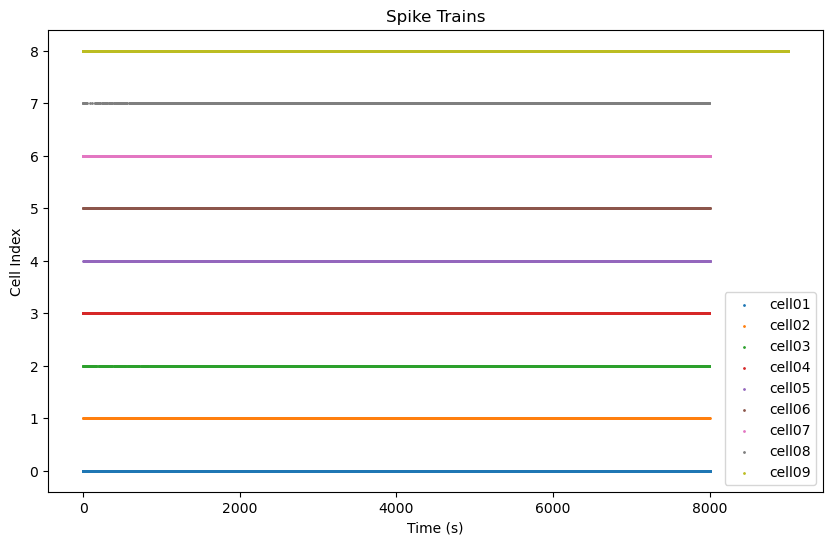

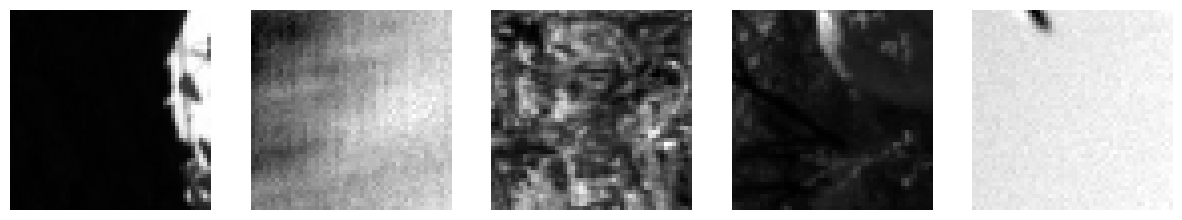

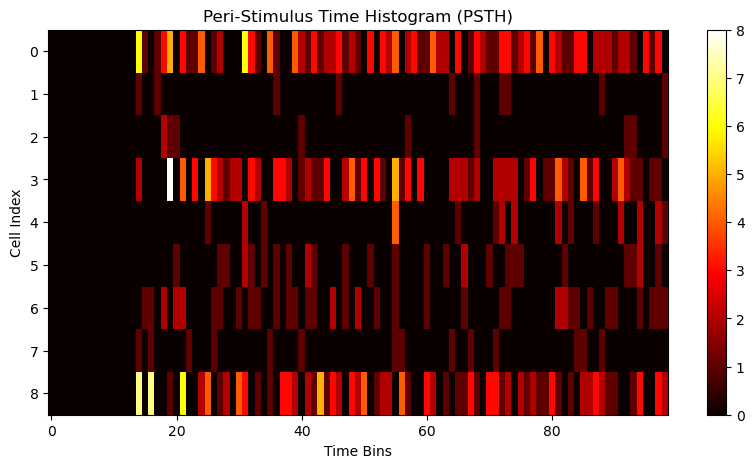

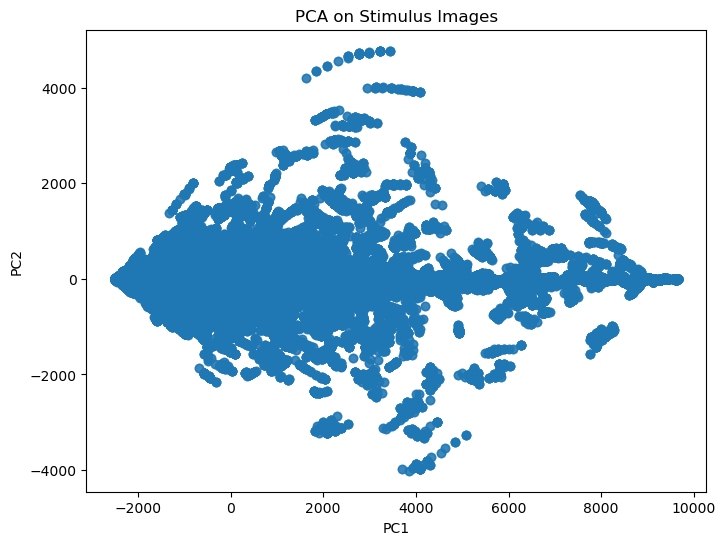

In [7]:
# File Paths
ganglion_path = r'C:\Users\nisha\Downloads\neural_code_data\neural_code_data\ganglion_cell_data\15-10-07\naturalscene.h5'
interneuron_path = r'C:\Users\nisha\Downloads\neural_code_data\neural_code_data\interneuron_data\amacrines_early_2012.h5'

# Run the functions
explore_h5(ganglion_path)
plot_spike_trains(ganglion_path)
plot_stimulus_images(ganglion_path)
compute_psth(ganglion_path)

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge

In [9]:
def train_neural_encoding_model(file_path):
    with h5py.File(file_path, 'r') as f:
        stimuli = f['train/stimulus'][:]
        responses = f['train/response/firing_rate_10ms'][:]
        
        stimuli_reshaped = stimuli.reshape(stimuli.shape[0], -1)
        X_train, X_test, y_train, y_test = train_test_split(stimuli_reshaped, responses.T, test_size=0.2, random_state=42)
        
        model = Ridge(alpha=1.0)
        model.fit(X_train, y_train)
        
        score = model.score(X_test, y_test)
        print(f"Model R^2 Score: {score:.3f}")

In [10]:
train_neural_encoding_model(ganglion_path)

Model R^2 Score: 0.014


In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GaussianNoise(nn.Module):
    def __init__(self, std=0.1):
        super(GaussianNoise, self).__init__()
        self.std = std

    def forward(self, x):
        if self.training:  # Add noise only during training
            return x + torch.randn_like(x) * self.std
        return x

In [31]:
class RetinaCNN(nn.Module):
    
    def __init__(self, input_channels=1, conv_channels=[16, 32], kernel_sizes=[5, 3], 
                 fc_units=128, output_units=9, noise_std=0.1, use_softplus=True):
        """
        input_channels: int
            Number of input channels (grayscale images: 1)
        conv_channels: list of ints
            Number of channels for each convolutional layer
        kernel_sizes: list of ints
            Kernel sizes for convolutional layers
        fc_units: int
            Number of units in the fully connected layer
        output_units: int
            Number of output neurons (matches number of ganglion cells)
        noise_std: float
            Standard deviation of Gaussian noise layer
        use_softplus: bool
            Whether to use Softplus activation at the output layer
        """
        super(RetinaCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(input_channels, conv_channels[0], kernel_size=kernel_sizes[0])
        self.bn1 = nn.BatchNorm2d(conv_channels[0])
        self.conv2 = nn.Conv2d(conv_channels[0], conv_channels[1], kernel_size=kernel_sizes[1])
        self.bn2 = nn.BatchNorm2d(conv_channels[1])
        
        self.fc1_input_size = conv_channels[1] * 44 * 44
        
        self.fc1 = nn.Linear(self.fc1_input_size, fc_units)
        self.fc_bn = nn.BatchNorm1d(fc_units)
        self.fc2 = nn.Linear(fc_units, output_units)
        
        self.noise = GaussianNoise(noise_std)
        self.use_softplus = use_softplus

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.noise(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.noise(x)
        
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = self.fc_bn(x)
        x = F.relu(x)
        
        x = self.fc2(x)
        return F.softplus(x) if self.use_softplus else torch.exp(x)

In [33]:
import torch

# Define the model
model = RetinaCNN(
    input_channels=1,      
    conv_channels=[16, 32], 
    kernel_sizes=[5, 3],    
    fc_units=128,           
    output_units=9,        
    noise_std=0.1,          # Gaussian noise standard deviation
    use_softplus=True      

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

batch_size = 16
input_tensor = torch.randn(batch_size, 1, 50, 50).to(device)

output = model(input_tensor)
print(output.shape)  # Expected: (batch_size, 9), where 9 = output neurons (ganglion cells)

torch.Size([16, 9])


In [35]:
criterion = torch.nn.MSELoss()  # Example loss function

In [73]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(100):
    model.train() 
    
    optimizer.zero_grad()
    output = model(input_tensor) 
    target = torch.randn(batch_size, 9).to(device) 
    
    loss = criterion(output, target)  
    loss.backward()  
    optimizer.step()  
    
    print(f"Epoch [{epoch+1}/100], Loss: {loss.item():.4f}")


Epoch [1/1000], Loss: 1.1232
Epoch [2/1000], Loss: 1.1458
Epoch [3/1000], Loss: 1.0709
Epoch [4/1000], Loss: 0.9727
Epoch [5/1000], Loss: 1.0314
Epoch [6/1000], Loss: 1.0852
Epoch [7/1000], Loss: 0.9681
Epoch [8/1000], Loss: 1.0316
Epoch [9/1000], Loss: 1.0990
Epoch [10/1000], Loss: 1.0327
Epoch [11/1000], Loss: 1.0597
Epoch [12/1000], Loss: 1.0058
Epoch [13/1000], Loss: 1.0501
Epoch [14/1000], Loss: 0.8704
Epoch [15/1000], Loss: 1.0366
Epoch [16/1000], Loss: 1.1299
Epoch [17/1000], Loss: 0.9431
Epoch [18/1000], Loss: 0.8376
Epoch [19/1000], Loss: 1.1350
Epoch [20/1000], Loss: 1.0731
Epoch [21/1000], Loss: 0.8551
Epoch [22/1000], Loss: 1.0505
Epoch [23/1000], Loss: 0.9971
Epoch [24/1000], Loss: 1.1185
Epoch [25/1000], Loss: 1.1256
Epoch [26/1000], Loss: 1.1108
Epoch [27/1000], Loss: 0.9948
Epoch [28/1000], Loss: 1.0064
Epoch [29/1000], Loss: 0.9661
Epoch [30/1000], Loss: 0.9608
Epoch [31/1000], Loss: 0.8741
Epoch [32/1000], Loss: 0.8623
Epoch [33/1000], Loss: 1.1361
Epoch [34/1000], Lo

In [74]:
torch.save(model.state_dict(), "retina_cnn.pth")

In [75]:
model.load_state_dict(torch.load("retina_cnn.pth"))
model.eval()  

C:\Users\nisha\AppData\Local\Temp\ipykernel_20804\2649317080.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("retina_cnn.pth"))


RetinaCNN(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=61952, out_features=128, bias=True)
  (fc_bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=128, out_features=9, bias=True)
  (noise): GaussianNoise()
)

In [76]:
model.eval()  
with torch.no_grad(): 
    test_input = torch.randn(1, 1, 50, 50).to(device)  # Single test image
    prediction = model(test_input)
    print(prediction)

tensor([[0.3849, 0.3404, 0.3587, 0.3676, 0.3609, 0.3826, 0.3958, 0.4053, 0.3730]])


In [77]:
import h5py
import torch
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr

# Load the test data
file_path = r'C:\Users\nisha\Downloads\neural_code_data\neural_code_data\ganglion_cell_data\15-10-07\naturalscene.h5'
with h5py.File(file_path, 'r') as f:
    test_stimulus = f['/test/stimulus'][:]  # Shape: (5996, 50, 50)
    test_response = f['/test/response/binned'][:]  # Shape: (9, 5997)

# Convert to PyTorch tensors
test_stimulus = torch.tensor(test_stimulus, dtype=torch.float32).unsqueeze(1)  # Add channel dimension
test_response = torch.tensor(test_response, dtype=torch.float32).T  # Transpose to (5997, 9)

# Move data to the same device as the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_stimulus = test_stimulus.to(device)
test_response = test_response.to(device)

# Set the model to evaluation mode
model.eval()

# Generate predictions
with torch.no_grad():
    predictions = model(test_stimulus)  # Shape: (5996, 9)

# Ensure predictions and ground truth have the same shape
predictions = predictions.cpu().numpy()  # Convert to NumPy
ground_truth = test_response.cpu().numpy()[:5996, :]  # Trim to match predictions

# Calculate evaluation metrics
mse = mean_squared_error(ground_truth, predictions)
mae = mean_absolute_error(ground_truth, predictions)
r2 = r2_score(ground_truth, predictions)

# Calculate Pearson correlation
pearson_corr = np.mean([pearsonr(ground_truth[:, i], predictions[:, i])[0] for i in range(9)])

# Print results
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R² Score: {r2}")
print(f"Pearson Correlation: {pearson_corr}")

Mean Squared Error (MSE): 0.032283175736665726
Mean Absolute Error (MAE): 0.09790048003196716
R² Score: -3.9673283100128174
Pearson Correlation: -0.04028712322161669


In [78]:
import h5py

# Open the HDF5 file at the specified path
ganglion_path = r'C:\Users\nisha\Downloads\neural_code_data\neural_code_data\ganglion_cell_data\15-10-07\naturalscene.h5'

with h5py.File(ganglion_path, 'r') as f:
    # Access the binned firing rate data (this will be the target variable)
    target_values_train = f['train/response/binned'][:]
    target_values_test = f['test/response/binned'][:]
    
    # Print the target values (e.g., print first 10 values from training data)
    print("Training Target Values (first 100 samples):")
    print(target_values_train[:100])
    
    # Similarly for test data
    print("\nTest Target Values (first 100 samples):")
    print(target_values_test[:100])

Training Target Values (first 100 samples):
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

Test Target Values (first 100 samples):
[[0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 ...
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.4 ... 0.  0.  0. ]]
